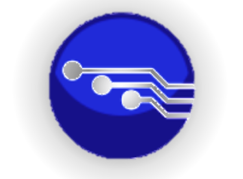

# <center> Unsupervised Learning Methods </center>
## <center> Problem Set IV </center>
### <center> MDS, Isomap and Laplacian-Eigenmaps, t-SNE </center>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Classical MDS
## 1.5 Implementation
Implement the following `CMDS` class:
* `FitTransform` - Given $\boldsymbol{D}_{xx}\in\mathbb{R}^{N_x\times N_x}$:
    1. Learns the encoding parameters.
    2. Obtains a low-dimensional representation.
* `Transform` - Given $\boldsymbol{D}_{xy}\in\mathbb{R}^{N_x\times N_y}$, applies (out of sample) encoding.

**Notes:**
* $\boldsymbol{D}_{xx}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}^2$
* $\boldsymbol{D}_{xy}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{y}_{j}\right\Vert _{2}^2$
* See Isomap lecture notes for the OOSE part.
* **Do not use any `for` (or `while`) loop!**

In [4]:
from scipy.sparse.linalg import svds

class CMDS:
    def __init__(self, d):
        self.d = d
  
    def FitTransform(self, mDxx):
        '''
        ===============================================================================
        Learns model's parameters
        Args:
            mDxx - Training (squared) pair-wise distances,      mDxx.shape = (Nx, Nx)
        Output:
            mZ   - Low-dimensional representation (embeddings), mZ.shape   = (d,  Nx)
        ===============================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be ~10 lines of code
        ==============================================
        '''
        
        self.mDxx = mDxx
        self.mDxx_tilde = (mDxx - np.mean(mDxx, axis=0))
        self.mDxx_tilde = -0.5 * (self.mDxx_tilde - np.mean(self.mDxx_tilde, axis=1)[:, None])

        svds_values = svds(A=self.mDxx_tilde, k=self.d, which="LM")

        eigen_vectors, singular_values = svds_values[0], np.sqrt(svds_values[1])


        idx = singular_values.argsort()[::-1]
        self.mVd = eigen_vectors[:, idx]
        self.singular_values = singular_values[idx]

        mZ = np.diag(self.singular_values) @ self.mVd.T
       
    
    
        return mZ
    
    def Transform(self, mDxy):
        '''
        ===========================================================================================================
        Applies (out of sample) encoding
        Args:
            mDxy - (Squared) pair-wise distances between the training data and the OOS data,  mDxy.shape = (Nx, Ny)
        Output:
            mZ   - Low-dimensional representation (embeddings),                               mZ.shape   = (d,  Ny)
        ===========================================================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be about 5-10 lines of code
        ==============================================
        '''
        k_tilde_x_y = mDxy - np.sum(self.mDxx, axis=0)[:, None] / mDxy.shape[0]
        k_tilde_x_y = -0.5 * (k_tilde_x_y - np.mean(k_tilde_x_y, axis=0))

        mZ = np.linalg.inv(np.diag(self.singular_values)) @ self.mVd.T @ k_tilde_x_y

    
        return mZ

# Metric MDS
## 1.6 Implementation
Implement the following `MMDS` class:
* `FitTransform` - Given $\boldsymbol{D}_{xx}\in\mathbb{R}^{N_x\times N_x}$, obtains a low-dimensional representation.

**Notes:**
* $\boldsymbol{D}_{xx}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}$ (not squared).
* Stop iterate after `maxIter` or if $\left\Vert {\boldsymbol{Z}}^{\left(t+1\right)}-\boldsymbol{Z}^{\left(t\right)}\right\Vert _{F}\leq\epsilon$.
* You may initialize $\boldsymbol{Z}^{\left(0\right)}$ randomly.
* **Do not use any `for` (or `while`) loop except the main (Majorization Minimization) loop.**


In [5]:
from scipy.spatial.distance import cdist

class MMDS:
    def __init__(self, d):
        self.d = d
        
    def FitTransform(self, mDx, maxIter=500, ε=1e-6):
        '''
        =============================================================================
        Applies metric-MDS
        Args:
            mDxx - Training pair-wise distances,                mDxx.shape = (Nx, Nx)
        Output:
            mZ   - Low-dimensional representation (embeddings), mZ.shape   = (d,  Nx)
        =============================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be 10-15 lines of code
        ==============================================
        '''
        N = mDx.shape[0]
        Z_t = np.random.random((self.d, N))

        for _ in range (maxIter):
          D_z = cdist(Z_t.T, Z_t.T) 

          Z_tilde = Z_t 
          C = -np.divide(mDx, D_z, where= D_z!=0)
          C = C - np.diag(C)
          B = C - np.diag(np.sum(C, 1))

          Z_t = Z_tilde @ B / N

          if np.linalg.norm(Z_tilde - Z_t) < ε:
            break
          
          mZ = Z_t

    
        return mZ    

# Isomap
## 2.3 Implementation
Implement the following `Isomap` class:
* `FitTransform` - Given $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$:
    1. Learns the encoding parameters (both training encoding and OOS encoding).
    2. Applies the training encoding to $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$.
* `Transform` - Given $\boldsymbol{Y}\in\mathbb{R}^{d\times N_{y}}$, applies (out of sample) encoding.

**Notes:**
* You may use `sklearn.neighbors.kneighbors_graph` to construct the graph:
    * For example:
    ```python
    mG = kneighbors_graph(mX.T, K, mode='distance')
    mG = mG.maximum(mG.T) #-- Make G symmetric
    ```
    * Note the `mG` is a sparse `csr_matrix` and not `ndarray`.
* Use `scipy.sparse.csgraph.connected_components` to check if the graph is connected.  
If not, print a warning (and consider to increase the value of `K`).
* You may use `scipy.sparse.csgraph.shortest_path` to compute all-pairs shortest path.
* **Do not use any `for` (or `while`) loop!**

**Tips:**
* Use your `CMDS` class (within the `Isomap` class).
* For the `Transform` method, you may use `sklearn.neighbors.NearestNeighbors`.

In [3]:
from sklearn.neighbors    import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import shortest_path, connected_components
from scipy.sparse import csr_matrix


In [16]:

class Isomap:
    def __init__(self, d, K):
      self.K = K
      self.d = d
      self.cmds = CMDS(self.d)
        
    def FitTransform(self, mX):
        '''
        ========================================================================
        Learns model's parameters
        Args:
            mX - Input training data,                         mX.shape = (D, Nx)
        Output:
            mZ - Low-dimensional representation (embeddings), mZ.shape = (d, Nx)
        ========================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be ~10 lines of code
        ==============================================
        '''
        self.neigh = NearestNeighbors(1)
        self.neigh.fit(mX.T)
        
        mG = kneighbors_graph(mX.T, self.K, mode='distance')
        mG = mG.maximum(mG.T) #-- Make G symmetric

        num_connected_components = connected_components(mG, directed=False, return_labels=False) > 1
        if (num_connected_components > 1):
          print("warning: graph is not connected, number od connected components is ", num_connected_components)
        
        self.dXX = shortest_path(mG, directed=False)
        mZ = self.cmds.FitTransform(self.dXX ** 2)


        return mZ
    
    def Transform(self, mY):
        '''
        ========================================================================
        Applies (out of sample) encoding
        Args:
            mY - OOS data,                                    mY.shape = (D, Ny)
        Output:
            mZ - Low-dimensional representation (embeddings), mZ.shape = (d, Ny)
        ========================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be 5-10 lines of code
        ==============================================
        '''
        distances, indices = self.neigh.kneighbors(mY.T, return_distance=True)
        dXY = self.dXX[:, indices.reshape(-1)] ** 2 + distances.T
        mZ = self.cmds.Transform(dXY)
        return mZ


# Laplacian-Eigenmaps
## 3.3 Implementation
Implement the following `LaplacianEigenmaps` class:
* `FitTransform` - Given $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$, obtains a low-dimensional representation.

**Notes:**
* Set $\sigma=\sigma_{\mathrm{Gain}}\cdot\mathrm{median}\left\{ \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}\right\} $,  
where `σGain` is some number (usually, between 0.1 - 10).
* Since the graph-Laplacian $\boldsymbol{L}=\boldsymbol{D}-\boldsymbol{W}$ is SPSD use `scipy.sparse.linalg.eigsh`
* Recall that if the graph is connected, the first eigenvector is constant and thus should be omitted.
* **Do not use any `for` (or `while`) loop!**

In [7]:
from scipy.sparse.linalg import eigsh


In [12]:

class LaplacianEigenmaps:
    def __init__(self, d, K):
        self.d = d
        self.K = K
        
    def FitTransform(self, mX, σGain=1):
        '''
        ========================================================================
        Learns model's parameters
        Args:
            mX - Input training data,                         mX.shape = (D, Nx)
        Output:
            mZ - Low-dimensional representation (embeddings), mZ.shape = (d, Nx)
        ==========================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be ~10 lines of code
        ==============================================
        '''
        
        sigma = np.median(cdist(mX.T, mX.T)) * σGain
        mG = kneighbors_graph(mX.T, self.K, mode='distance')
        mG = mG.maximum(mG.T).toarray() ** 2  # -- Make G symmetric
        W = np.exp(-1 * (mG / (2 * (sigma ** 2))))
        W = np.where(mG > 0, mG, 0)

        D = np.diag(np.sum(W, 1))
        L = D - W

        eigen_values, eigen_vectors = eigsh(L, which="SM", k=self.d + 1)
        idx = eigen_values.argsort()

        num_connected_components = connected_components(mG, directed=False, return_labels=False)
        if (num_connected_components == 1):
            print("LaplacianEigenmaps: the graph is connected, removing the first eigenvector")
            mZ = eigen_vectors[:, idx][:, 1:]
        else:
            mZ = eigen_vectors[:, idx][:, : -1]

        return mZ.T

## Test Your Methods
### Run the two cells below to test your implementations
#### Generate and plot data:

In [5]:
from sklearn.datasets     import make_s_curve, make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D 

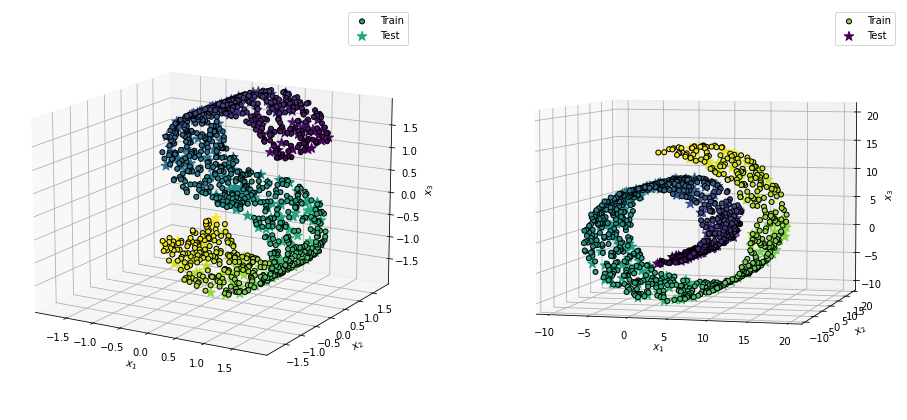

In [13]:


np.random.seed(0)

def GetData(MakeData, Nx, Ny):
    mX, vCx = MakeData(Nx)
    mY, vCy = MakeData(Ny)
    
    return mX.T, mY.T, vCx, vCy
    
def PlotData(mX, mY, vCx, vCy, ax):
    m = mX.min()
    M = mX.max()
    
    ax.scatter   (*mX, s=25,  c=vCx, edgecolor='k', alpha=1, label='Train', vmin=vCx.min(), vmax=vCx.max())
    ax.scatter   (*mY, s=100, c=vCy, marker='*',    alpha=1, label='Test' , vmin=vCx.min(), vmax=vCx.max())
    ax.set_xlim  ([m, M])
    ax.set_ylim  ([m, M])
    ax.set_zlim  ([m, M])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    ax.legend    ()

Nx = 1000
Ny = 250
mX1, mY1, vCx1, vCy1 = GetData(make_s_curve,    Nx, Ny)
mX2, mY2, vCx2, vCy2 = GetData(make_swiss_roll, Nx, Ny)
    
fig = plt.figure     (figsize=(16, 8))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax1.view_init        (elev=15, azim=300)
ax2.view_init        (elev=5,  azim=285)

PlotData(mX1, mY1, vCx1, vCy1, ax1)
PlotData(mX2, mY2, vCx2, vCy2, ax2)

#### Apply methods:

In [35]:
lData     = []
lData    += [(mX1, mY1, vCx1, vCy1)]
lData    += [(mX2, mY2, vCx2, vCy2)]

lMethods  = []
lMethods += [(CMDS              (d=2),       'Classical MDS')      ]
lMethods += [(MMDS              (d=2),       'Metric MDS')         ]
lMethods += [(Isomap            (d=2, K=8),  'Isomap')             ]
lMethods += [(LaplacianEigenmaps(d=2, K=12), 'Laplacian Eigenmaps')]

fig, mAxes = plt.subplots(2, 5, figsize=(28, 10))
for ii, (mX, mY, vCx, vCy) in enumerate(lData):
    for jj, (oMap, name) in enumerate(lMethods, 1):
        if   name == 'Classical MDS'      : mZx = oMap.FitTransform(cdist(mX.T, mX.T)**2); mZy = oMap.Transform(cdist(mX.T, mY.T)**2)
        elif name == 'Metric MDS'         : mZx = oMap.FitTransform(cdist(mX.T, mX.T))   ; mZy = np.full((2, Ny), np.nan)
        elif name == 'Isomap'             : mZx = oMap.FitTransform(mX)                  ; mZy = oMap.Transform(mY)
        elif name == 'Laplacian Eigenmaps': mZx = oMap.FitTransform(mX)                  ; mZy = np.full((2, Ny), np.nan)

        ax = mAxes[ii,jj]
        ax.scatter(*mZx, s=25,  c=vCx, edgecolor='k')
        ax.scatter(*mZy, s=100, c=vCy, marker='*')
        ax.set_xlabel('$z_1$')
        ax.set_ylabel('$z_2$')
        ax.set_title(name)
        ax.axis('equal')
    
    mAxes[ii,0].remove()
    PlotData(mX, mY, vCx, vCy, fig.add_subplot(2, 5, 1+5*ii, projection='3d'))

fig.axes[-2].view_init(elev=15, azim=300)
fig.axes[-1].view_init(elev=5,  azim=285)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

TypeError: __init__() takes 1 positional argument but 2 were given

## 3.4 Spectral-Clustering (5% Bonus)
Consider the following dataset:

#### Load data:

In [3]:
from scipy.io import loadmat

file = "Rings5.mat"

mX = loadmat(file)['pointCloud']
mX.shape

(3, 1000)

#### Plot data (and apply K-Means):

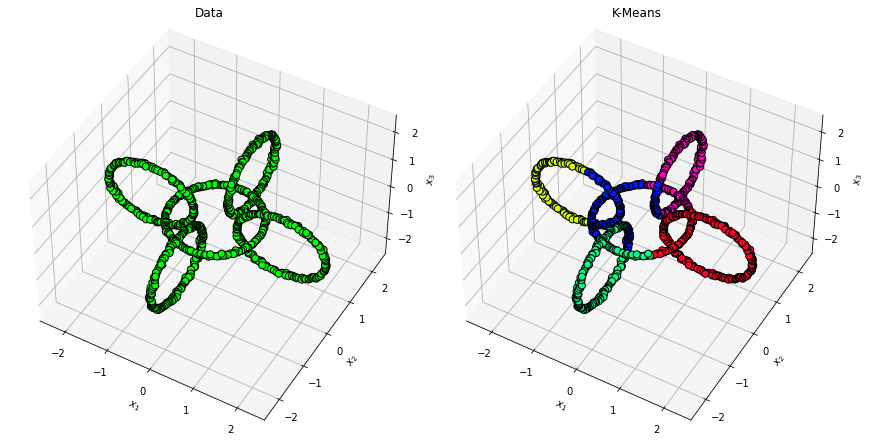

In [4]:
from sklearn.cluster import KMeans
from matplotlib.cm   import get_cmap

def PlotRings(mX, vC, title, ax):
    m = mX.min()
    M = mX.max()
    ax.scatter(*mX, s=50,  c=vC, edgecolor='k', alpha=1, cmap=get_cmap('gist_rainbow', len(np.unique(vC))))
    ax.set_xlim([m, M])
    ax.set_ylim([m, M])
    ax.set_zlim([m, M])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    ax.view_init(elev=45, azim=300)
    ax.set_title(title)


vIdxKMeans = KMeans(5).fit_predict(mX.T)
    
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
PlotRings(mX, 'lime',     'Data',    ax1)
PlotRings(mX, vIdxKMeans, 'K-Means', ax2)


plt.tight_layout()
plt.show()

In [6]:
from sklearn.cluster import KMeans

K  = 5
'''
==============================================
Write your code below.
It should be 1-5 lines of code
==============================================
'''

mZx = LaplacianEigenmaps(d=K, K=K).FitTransform(mX) 
vIdxSC = KMeans(n_clusters=K, random_state=0).fit(mZx.T).labels_

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
PlotRings(mX, vIdxKMeans, 'K-Means',             ax1)
PlotRings(mX, vIdxSC,     'Spectral Clustering', ax2)

plt.tight_layout()
plt.show()

NameError: name 'LaplacianEigenmaps' is not defined

* Implement Spectral-Clustering:
    * Apply Laplacian-Eigenmaps with $d=K$, keep the first eigenvector (if it is not constant).
    * Apply K-Means, you may use `sklearn.cluster.KMeans`.
    * You might need to add one line of code to your `LaplacianEigenmaps` class.

# t-SNE
## 4.6 Perplexity - setting the variances
Implement the function `ComputeSTD`.
* Given:  
    * The point $\boldsymbol{x}_{i}\in\mathbb{R}^{D}$.
    * $\mathcal{N}_{i}$, the $K$th nearest neighbors of $\boldsymbol{x}_i$ (exclusive $\boldsymbol{x}_i$).
    * `PP` The perplexity value.
* The function computes $\sigma_{i}\pm\epsilon$, such that:
$$2^{H\left(\boldsymbol{x}_{i}\right)}=PP$$
where:
    $$H\left(\boldsymbol{x}_{i}\right)=-\sum_{j=1}^{K}p_{j|i}\log\left(p_{j|i}\right)$$
    
**Tip:** Since $2^{H\left(\boldsymbol{x}_{i}\right)}$ is monotonic increasing with $\sigma_{i}$, use binary search.

**Note:**
Compute all STDs with a **single** (binary search) loop.

In [72]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

In [79]:
def calc_mP(mD, vσ):
  mP =  np.exp(-mD / (2 * np.square(vσ))[:, None])
  return mP / mP.sum(axis=1)[:, None]

def calculate_PP(mD, vσ):
      mP = calc_mP(mD, vσ)
      vH = -np.sum(mP * np.log2(mP), 1)
      return 2 ** vH
    
    

In [80]:
from scipy.stats import norm

#-- Option II:
def ComputeSTD(mX, mD, PP, ε=1e-2):
    '''
    ===============================================================================
    Compute the std σ (for each data-point)
    Args:
        mX - The input dataset,                                          mX.shape = (D, N)
        mD - The distance from each point to its K'th nearset neighbors, mD.shape = (N, K)
        PP - Perplexity value,                                           PP > 0
        ε  - threshold for the binary search,                            ε  > 0
    Output:
        vσ - The std,                                                    vσ.shape = (N,)                              
    ===============================================================================
    ''' 
    
    '''
    ==============================================
    Write your code below.
    It should be 10-15 lines of code
    ==============================================
    '''
    # prubt(mX)
    D, N = mX.shape
    vLeft = (ε / 100000)  * np.ones(N)
    vRight =  PP * 2 * np.ones(N)

    while np.max(vRight - vLeft) > ε:
      vσ = (vRight + vLeft) / 2

      vPP = calculate_PP(mD, vσ)
      
      vIdx = vPP < PP

      vLeft[vIdx] = vσ[vIdx]
      vRight[~vIdx] = vσ[~vIdx]
    
    return vσ

#### Test your implementation:

In [81]:
from sklearn.neighbors import kneighbors_graph, NearestNeighbors

#-- Some random data:
mX       = np.random.randn(2, 1000)
oNN      = NearestNeighbors(n_neighbors=50).fit(mX.T)
mD, mIdx = oNN.kneighbors(mX.T, return_distance=True)
mN       = mX[:,mIdx[:,1:]]

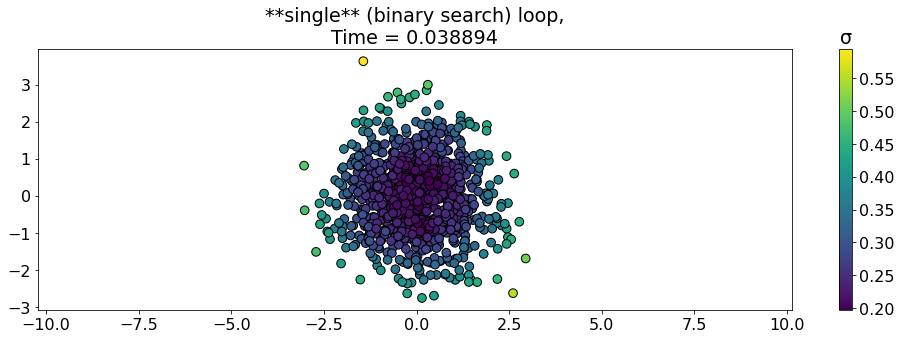

In [85]:
import time
D, N = mX.shape
PP   = 30
Op = lambda: ComputeSTD(mX, mD, PP)          
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
start = time.time()
vσ    = Op1() 
end   = time.time()
h = ax.scatter(*mX, s=75, c=vσ, edgecolor='k')
ax.axis       ('equal')
ax.set_title  (f'**single** (binary search) loop,\nTime = {end - start:3.6f}')
plt.colorbar  (h, ax=ax).ax.set_title('σ')
plt.tight_layout()
plt.show()

## 4.7 Implement `TSNE`
Implement the following `TSNE` class:
* `FitTransform` - Given $\boldsymbol{X}\in\mathbb{R}^{D\times N}$, obtains a low-dimensional representation.

**Notes:**
* Use must use a **single** loop.
* Use gradient descent with momentum.
* You may use the dynamic plot part for a nice visual animation of the algorithm:
    * Only works on `Jupyter`
    * Use `%matplotlib notebook` (instead of `%matplotlib inline`)
    * If you do not this, plot the final result with a `scatter` plot.
* **3% Bonus: Optimization tricks**
    * *Early compression:* In the first (50) iterations, add the penalty $\lambda\left\Vert \boldsymbol{Z}\right\Vert _{F}^{2}$ to the objective.  
    (**Update** your gradient accordingly)
    
    * *Early exaggeration:* In the first (50) iterations, use $4\boldsymbol{P}$ instead of $\boldsymbol{P}$.
    * After (about 100-200) iterations, update the momentum to $\beta=0.8$.
    


In [ ]:
class TSNE:
    def __init__(self, d=2, K=50, PP=20, numIter=300, µ=100, ß=0.5, λ=1e-4):
        '''
        ========================================================================
        Set the hyper-parameters
        Args:
            d       - The output dimensionality.
            K       - Number of neareast neighbors.
            PP      - The perpelxity value.
            numIter - Number of iterations.
            µ       - Step size.
            ß       - Momentum decaying factor
            λ       - L² regularization factor (Early compression).
        ========================================================================
        '''
        self.d = d
        self.K = K
        self.PP = PP
        self.numIter = numIter
        self.µ = µ
        self.ß = ß
        self.λ = λ

    def FitTransform(self, mX, vY=None):
        '''
        ========================================================================
        Applies the t-SNE algorithm
        Args:
            mX   - Input data,                                  mX.shape = (D, N)
            [vY] - Input labels, optional for dynamic plot,     vY.shape = (N,)
        Output:
            mZ   - Low-dimensional representation (embeddings), mZ.shape = (d, N)
        ========================================================================
        '''
        d = self.d
        K = self.K
        PP = self.PP
        numIter = self.numIter
        µ = self.µ
        ß = self.ß
        λ = self.λ

        D, N = mX.shape

        # -- Compute σ:
        oNN = NearestNeighbors(n_neighbors=K).fit(mX.T)
        mD, mIdx = oNN.kneighbors(mX.T, return_distance=True)
        vσ = ComputeSTD2(mX, mD, PP)

        # -- Compute P:
        mP = np.zeros((N, N))
        mDP = calc_mP(mD, vσ)

        rows = np.indices((mP.shape[0],)).reshape(-1, 1)
        mP[rows, mIdx] = mDP
        mP = (mP + mP.T) / (2 * N)


        # -- Initialaization:
        mZ = np.random.randn(d, N)
        mZ_1 = mZ

        # -- Dynamic plot:
        color = 'b' if vY is None else vY
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.axis('equal')
        ax.set_xlabel('$z_1$')
        ax.set_ylabel('$z_2$')
        s = ax.scatter(*mZ)
        cax = None

        for ii in range(numIter):
            if ii == 150:
                B = 0.8

            # -- Compute Q:
            mQ = (cdist(mZ.T, mZ.T) ** 2 + 1) ** (-1)
            mQ -= np.diag(np.diag(mQ))
            mQ = mQ / np.sum(mQ)

            # -- Compute gradient:
            S = (cdist(mZ.T, mZ.T) ** 2 + 1) ** (-1)

            if ii < 50:
                A = np.multiply(4 * mP - mQ, S)
            else:
                A = np.multiply(mP - mQ, S)

            gradient = 4 * mZ @ (np.diag(np.sum(A, axis=0)) - A)
            if ii < 50:
              #since the gradient of  λ||Z||^2_F is 2λZ
              gradient += 2 * λ * mZ 

            # -- GD + momentum update:
            mZ_temp = mZ
            mZ = mZ - µ * gradient + ß * (mZ - mZ_1)
            mZ_1 = mZ_temp

            # -- Dynamic plot:
            s.remove()
            s = ax.scatter(*mZ, s=25, c=color, edgecolor='k', cmap='tab10', vmin=-1 / 2,
                           vmax=len(np.unique(color)) - 1 / 2)
            ax.set_title(f'{ii}')
            cax = plt.colorbar(s, ax=ax, cax=cax).ax.axes
            fig.canvas.draw   ()

            plt.show()

        return mZ

#### Test your implementation:

In [87]:
from sklearn.datasets import load_digits

mX, vY = load_digits(return_X_y=True)
mX.shape, vY.shape

((1797, 64), (1797,))

In [ ]:
%matplotlib notebook

mZ = TSNE(µ=25, K=50, PP=30).FitTransform(mX.T, vY)

<IPython.core.display.Javascript object>

# 5 BCI (Brain-Computer Interface) data
**The original datasets (datasets 2a):**  
http://www.bbci.de/competition/iv/#dataset2a

**Download from here:** [BciData.npz](https://drive.google.com/file/d/13KPmsZ9Sr4lux6R5MOLvt3LzdaOpTBAc/view?usp=sharing)

**TL;DR**:
* Motor-imagery classification task (4 labels - `['Left hand', 'Right hand', 'Foot', 'Tongue']`)
* Each sample is a multi-variate time series with $C=22$ channels.
* 4 seconds, 250 samples per second ($T=1,000$).

#### Load and plot the dataset:

In [11]:
dData = np.load('BciData.npz')

mX1   = dData['mX1']
mX2   = dData['mX2']
vY1   = dData['vY1']
vY2   = dData['vY2']

mX    = np.concatenate([mX1, mX2])
vY    = np.concatenate([vY1, vY2])

print(f'Day I:   mX1.shape = {mX1.shape}')
print(f'Day I:   vY1.shape = {vY1.shape}')
print(f'Day II:  mX2.shape = {mX2.shape}')
print(f'Day II:  vY2.shape = {vY2.shape}')
print(f'Combine: mX .shape = {mX .shape}')
print(f'Combine: vY .shape = {vY .shape}')

Day I:   mX1.shape = (287, 1000, 22)
Day I:   vY1.shape = (287,)
Day II:  mX2.shape = (288, 1000, 22)
Day II:  vY2.shape = (288,)
Combine: mX .shape = (575, 1000, 22)
Combine: vY .shape = (575,)


In [12]:
lLabel = ['Left hand', 'Right hand', 'Foot', 'Tongue'] #-- The labels

#-- N = Samples, T = Time, C = Channels
N1, T, C = mX1.shape
N2, _, _ = mX2.shape
N,  _, _ = mX .shape

#### Run the cell below several times

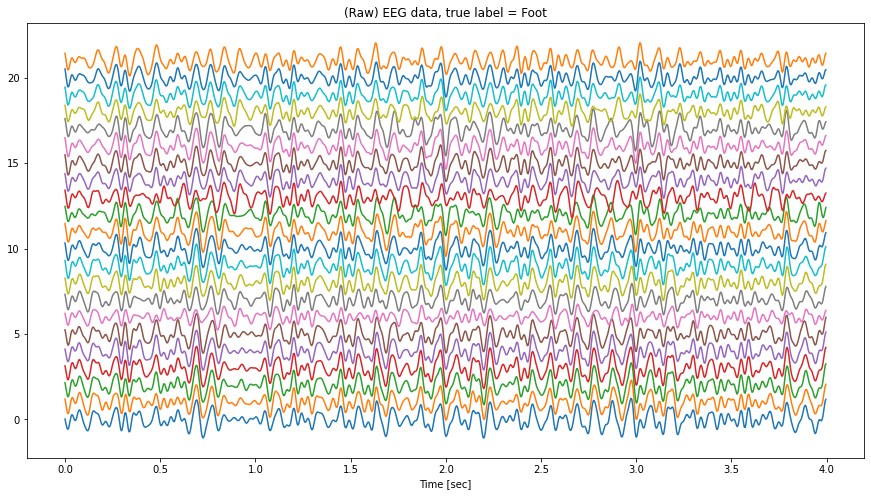

In [13]:
def PlotRandomSample(mX, vY):
    N, T, C = mX.shape #-- Samples, Time, Channels
    idx     = np.random.randint(N)
    mXi     = mX[idx,:,:].copy()
    yi      = vY[idx]
    
    #--  Just for plotting:
    mXi -= mXi.mean(0)
    mXi /= 20
    mXi += np.arange(C)[None,:]
    vT   = np.linspace(0, 4, T, endpoint=False)
    
    plt.figure(figsize=(15, 8))
    plt.plot  (vT, mXi)
    plt.title (f'(Raw) EEG data, true label = {lLabel[yi]}')
    plt.xlabel('Time [sec]')

PlotRandomSample(mX1, vY1)
plt.show()

## Analyzing
### Raw data - Euclidean metric
The cell below applies several dimensionality reduction methods to the raw EEG data (from day I).  
As you can see (after running the cell), the different labels do not form uniform clusters.

**Notes:**
* Use `sklearn` implementations
* Consider installing `UMAP`:<br>https://umap-learn.readthedocs.io/en/latest/  
(If not, omit this option)

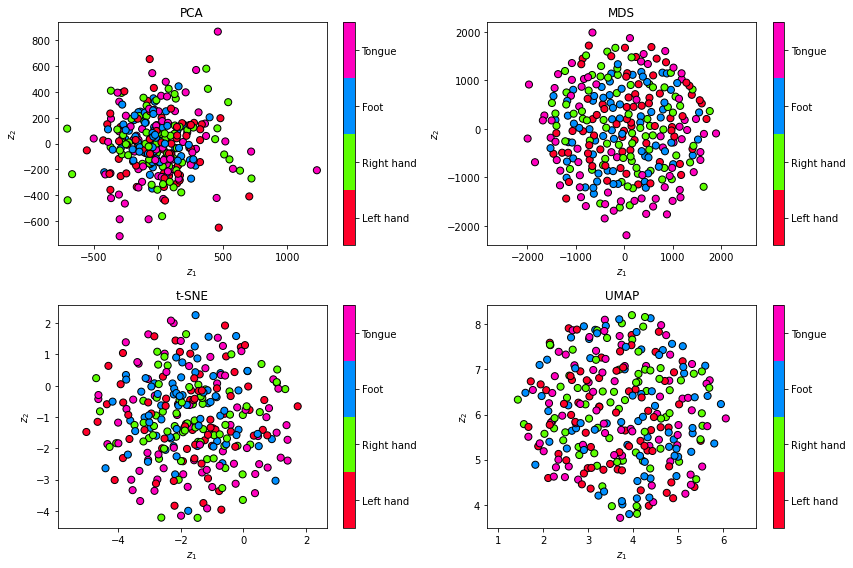

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold      import MDS, TSNE
from umap                  import UMAP
from matplotlib.cm         import get_cmap

lMethods  = []
lMethods += [(PCA (n_components=2), 'PCA'  )]
lMethods += [(MDS (n_components=2), 'MDS'  )]
lMethods += [(TSNE(n_components=2), 't-SNE')]
lMethods += [(UMAP(n_components=2), 'UMAP' )]

mX1A   = mX1.reshape((N1, -1))
fig, _ = plt.subplots(2, 2, figsize=(12, 8))
for (oMethod, name), ax in zip(lMethods, fig.axes):
    mZ = oMethod.fit_transform(mX1A)
    
    h = ax.scatter(*mZ.T, s=50, c=vY1, edgecolor='k', vmin=-1/2, vmax=3.5, cmap=get_cmap('gist_rainbow', 4))
    ax.set_title  (name)
    ax.set_xlabel ('$z_1$')
    ax.set_ylabel ('$z_2$')
    ax.axis       ('equal')
    plt.colorbar  (h, ax=ax, ticks=range(4)).ax.set_yticklabels(lLabel)   

plt.tight_layout()
plt.show        ()

---

## Feature extraction
* The raw data is inadequate as feature(s).
* Covariances (with a proper metric) are useful features for this task.
### 5.1
* Implement the following (short) `ComputeCovs` function.  
* **Do not use loops.**

In [16]:
def ComputeCovs(mX):
    '''
    ========================================================================
    The funciton computes the covariances of the input data
    Args:
        mX    - Input data,    mX   .shape = (N, T, C)
    Output:
        mCovs - N covariances, mCovs.shape = (N, C, C)
    ========================================================================
    '''
    
    '''
    ==============================================
    Write your code below.
    It should be 1-5 lines of code
    ==============================================
    '''
    mX_list = mX.tolist()
    convs = list(map(lambda x: np.array(x).T@np.array(x), mX_list))
    mCovs = np.array(convs)

    return mCovs

---

### SPD metric (geodesic distance)
A useful metric between SPD matrices:
$$d\left(\boldsymbol{P},\boldsymbol{Q}\right)=\sqrt{\sum_{i=1}^{d}\log^{2}\left(\lambda_{i}\left(\boldsymbol{P}^{-1}\boldsymbol{Q}\right)\right)}$$
**Implementation:**

In [17]:
from scipy.linalg import eigvalsh

def SpdMetric(P, Q):
    '''
    ========================================================================
    The funciton computes the AIRM geodesic distance between two SPD matrices.
    Args:
        P    - An SPD matrix,         P.shape = (d, d)
        Q    - An SPD matrix,         Q.shape = (d, d)
    Output:
        dist - The geodesic distance, dist ≥ 0
    ========================================================================
    '''
    vEig = eigvalsh(P, Q)
    return np.linalg.norm(np.log(vEig))

#### `SpdMetricAux`
Gets the column stack representation of two SPD matrices and computes the `SpdMetric` between them.

In [18]:
def SpdMetricAux(vP, vQ):
    d2 = len(vP)
    d  = np.sqrt(d2).astype(np.int)
    mP = np.reshape(vP, (d, d))
    mQ = np.reshape(vQ, (d, d))
    
    return SpdMetric(mP, mQ)

### 5.2
* Apply the different dimensionality reduction methods to the covariances `mCovs`.
* Use the geodesic distance between your covariances:
    * For `MDS` - use the `precomputed` option with `mD`.
    * For `t-SNE`\\`UMAP` -  use `SpdMetricAux`.
* Remember to reshape `mCovs`.
* Fill the missing `???`.
* You should get much better results.

In [ ]:

from sklearn.metrics import pairwise_distances
mCovs1 = ComputeCovs(mX1)
mCovs1_flatten = mCovs1.reshape(N1,-1)
mD    = pairwise_distances(mCovs1_flatten, metric=SpdMetricAux)

lMethods  = []
lMethods += [(MDS (n_components=2, dissimilarity="precomputed"), 'MDS'  )]
lMethods += [(TSNE(n_components=2, metric=SpdMetricAux       ), 't-SNE')]
lMethods += [(UMAP(n_components=2, metric=SpdMetricAux       ), 'UMAP' )]

fig, _ = plt.subplots(2, 2, figsize=(12, 8))
for (oMethod, name), ax in zip(lMethods, fig.axes):
    if name == 'MDS':
        mZ = oMethod.fit_transform(mD)
    else:
        mZ = oMethod.fit_transform(mCovs1_flatten)
    
    h = ax.scatter(*mZ.T, s=50, c=vY1, edgecolor='k', vmin=-1/2, vmax=3.5, cmap=get_cmap('gist_rainbow', 4))
    ax.set_title  (name)
    ax.set_xlabel ('$z_1$')
    ax.set_ylabel ('$z_2$')
    ax.axis       ('equal')
    plt.colorbar  (h, ax=ax, ticks=range(4)).ax.set_yticklabels(lLabel)   
    
plt.tight_layout()
plt.show()

### 5.3 (Bonus - supervised)
* Get the best leave-one-out cross validation accuracy on the BCI dataset.
* **Hints:**
    * Use the dimensionality reduction methods to extract useful features.
    * You may apply your dimensionality reduction to the entire dataset (train + test) as long as it is an unsupervised method.
    * $d$ does not have to be equal to $2$.
    * Above 85% accuracy is good (but one can do better).